In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"mahachaudhary","key":"814edbe761e1c2afeba0308c6e391d10"}'}

In [ ]:
# Rename and move kaggle (2).json to the correct path
!mkdir -p ~/.kaggle
!mv "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


DOWNLOADING THE DATASET

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset


Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.67G/2.70G [00:21<00:00, 239MB/s]
100% 2.70G/2.70G [00:21<00:00, 132MB/s]


UNZIP THE FILE


In [ ]:
from zipfile import ZipFile
import os

# Path to ZIP file
zip_path = "/content/new-plant-diseases-dataset.zip"
extract_path = "/content/plant_diseases"

# Unzip
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Dataset unzipped successfully to:", extract_path)


 Dataset unzipped successfully to: /content/plant_diseases


PATH FOR FILES

In [ ]:
import os
import shutil

# Remove redundant dataset if exists
redundant_path = "/content/plant_diseases/new plant diseases dataset(augmented)"
if os.path.exists(redundant_path):
    shutil.rmtree(redundant_path)

# Define source paths
base_path = '/content/plant_diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_src = os.path.join(base_path, 'train')
valid_src = os.path.join(base_path, 'valid')

# Selected classes
classes = ['Apple___Apple_scab', 'Corn_(maize)___healthy', 'Peach___healthy']

# Temp target paths
train_dest = '/content/temp_plant_diseases_train'
valid_dest = '/content/temp_plant_diseases_valid'

# Recreate temp folders
for d in [train_dest, valid_dest]:
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d)

# Copy selected class folders
for cls in classes:
    for src, dest in [(train_src, train_dest), (valid_src, valid_dest)]:
        src_path = os.path.join(src, cls)
        dest_path = os.path.join(dest, cls)
        if os.path.exists(src_path):
            shutil.copytree(src_path, dest_path)

print("Dataset prepared with 3 selected classes.")


Dataset prepared with 3 selected classes.


CNN-Based Image Classification Using TensorFlow & Keras

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 3
  # Make sure only 3 folders (classes) are in train/ and valid/


In [ ]:
# --- Paths ---
# Use the temporary directories created with selected classes
train_dir = '/content/temp_plant_diseases_train'
valid_dir = '/content/temp_plant_diseases_valid'

# --- Data Preprocessing ---
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5603 images belonging to 3 classes.
Found 1401 images belonging to 3 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# --- Paths ---
train_dir = '/content/temp_plant_diseases_train'
valid_dir = '/content/temp_plant_diseases_valid'

# --- Constants ---
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10

# --- 🔁 Data Preprocessing with STRONGER Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
print(f"✅ Detected number of classes: {NUM_CLASSES}")

# --- 🧠 CNN Model with Dropout + L2 Regularization ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# --- Compile Model ---
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# --- Callbacks ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.keras',  # Use modern .keras format
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# --- 🚀 Train Model ---
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


Found 5603 images belonging to 3 classes.
Found 1401 images belonging to 3 classes.
✅ Detected number of classes: 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7790 - loss: 0.9899

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.97787, saving model to best_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - accuracy: 0.7798 - loss: 0.9883 - val_accuracy: 0.9779 - val_loss: 0.4867
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9766 - loss: 0.5059
Epoch 2: val_accuracy improved from 0.97787 to 0.98501, saving model to best_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 185ms/step - accuracy: 0.9765 - loss: 0.5059 - val_accuracy: 0.9850 - val_loss: 0.4380
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9884 - loss: 0.4400
Epoch 3: val_accuracy improved from 0.98501 to 0.99001, saving model to best_model.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.9884 - loss: 0.4399 - val_accuracy: 0.9900 - val_loss: 0.4131
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9890 - loss: 0.4123
Epoch 4: val_accuracy did not improve from 0.99001
176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.98

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Classification Report:

                        precision    recall  f1-score   support

    Apple___Apple_scab       0.98      1.00      0.99       504
Corn_(maize)___healthy       1.00      1.00      1.00       465
       Peach___healthy       1.00      0.97      0.98       432

              accuracy                           0.99      1401
             macro avg       0.99      0.99      0.99      1401
          weighted avg       0.99      0.99      0.99      1401



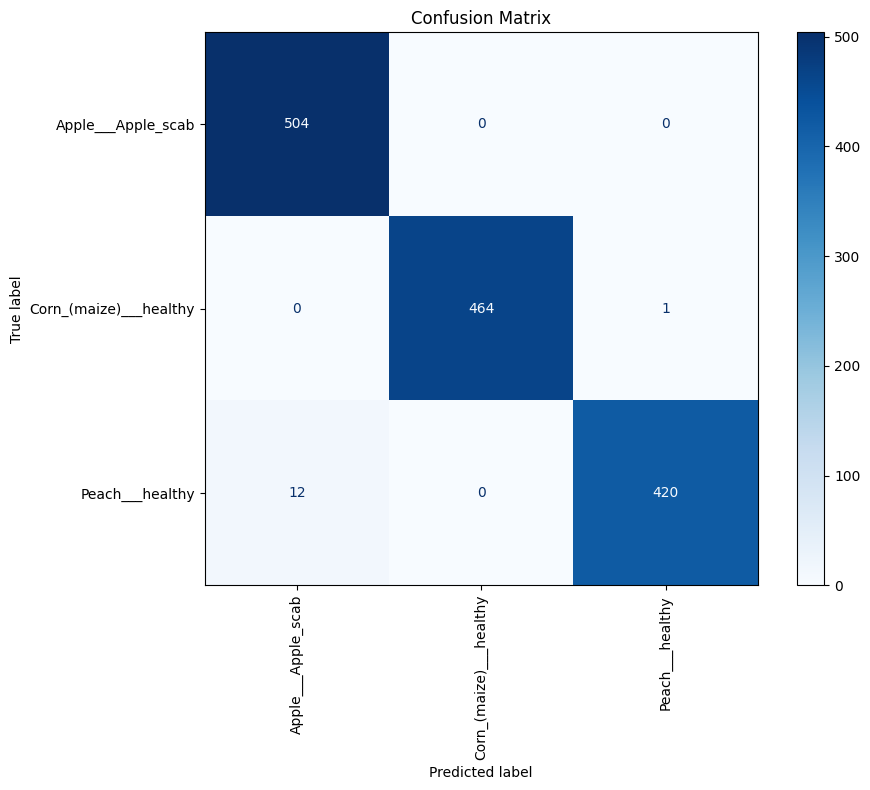

In [ ]:
# --- Evaluation ---
# Predicting on validation set
valid_generator.reset()
Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())

# Classification Report
print("Classification Report:\n")
# Use zero_division=0 to avoid warnings if a class has no true samples
print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# --- Improved Confusion Matrix Plotting ---
# Determine appropriate figure size based on the number of classes
num_classes_actual = len(class_labels)
fig_width = max(10, num_classes_actual * 0.5) # Adjust multiplier based on label length
fig_height = max(8, num_classes_actual * 0.4) # Adjust multiplier

plt.figure(figsize=(fig_width, fig_height)) # Set figure size before creating display object

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the matrix with adjusted figure size and rotated labels
disp.plot(cmap='Blues', ax=plt.gca()) # Use plt.gca() to plot on the created figure

plt.title("Confusion Matrix")
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()

Model Design and Training using TensorFlow (Keras):





Plotting training history...


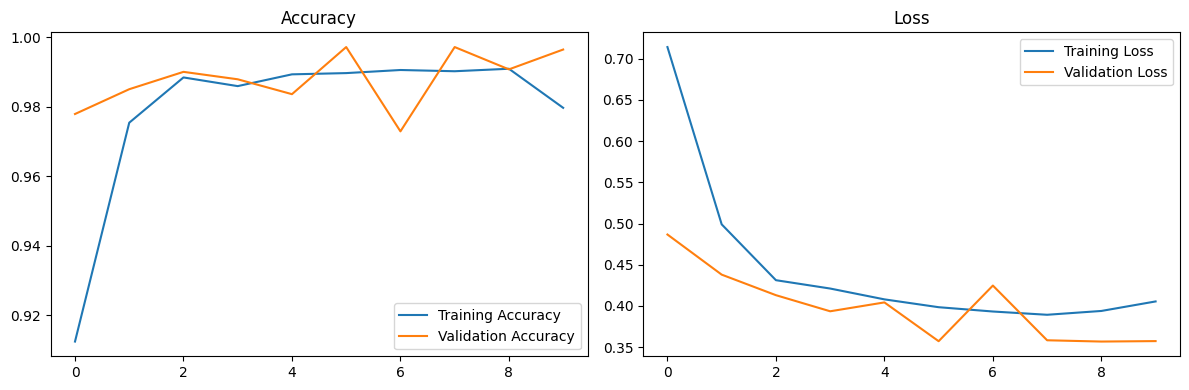

In [ ]:
# --- Plot Training History (Accuracy & Loss Only) ---
print("\nPlotting training history...")

history_dict = history.history
acc       = history_dict['accuracy']
val_acc   = history_dict['val_accuracy']
loss      = history_dict['loss']
val_loss  = history_dict['val_loss']
epochs    = range(len(acc))

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc,     label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss,     label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving AppleScab2.jpg to AppleScab2 (3).jpg


Using uploaded file: AppleScab2 (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
🔍 Predicted Class: Apple___Apple_scab


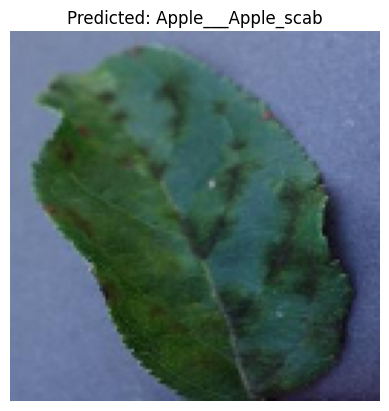

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os # Import os module

# Get the list of uploaded file names
uploaded_files = list(uploaded.keys())

# Check if any files were uploaded
if uploaded_files:
    # Use the first uploaded file name
    img_filename = uploaded_files[0]
    print(f"Using uploaded file: {img_filename}")

    # Path to uploaded image (now using the actual filename)
    img_path = os.path.join('/content/', img_filename) # Construct the full path

    # Load and preprocess image
    try:
        # Use IMG_SIZE[0] for height and IMG_SIZE[1] for width
        img = image.load_img(img_path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize (same as training)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        pred = model.predict(img_array)
        predicted_class_index = np.argmax(pred, axis=1)[0]

        # Get class label
        # Ensure class_labels are available (they should be from the generator)
        if 'class_labels' in globals() and predicted_class_index < len(class_labels):
             predicted_class_name = class_labels[predicted_class_index]
        else:
             predicted_class_name = f"Unknown Class Index: {predicted_class_index}"
             print("Warning: class_labels might not be correctly populated or index out of bounds.")


        # Display result
        print(f" Predicted Class: {predicted_class_name}")
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class_name}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file {img_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

else:
    print("No files were uploaded. Please upload an image file using files.upload().")

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving CORN_HEALTHY.jpg to CORN_HEALTHY (3).jpg


Using uploaded file: CORN_HEALTHY (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
🔍 Predicted Class: Corn_(maize)___healthy


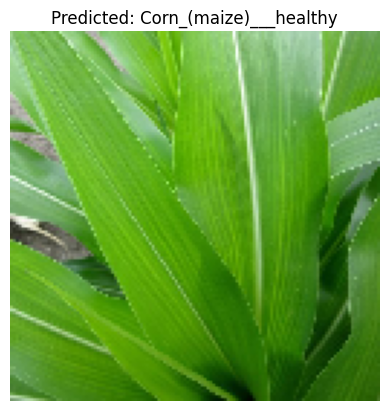

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os # Import os module

# Get the list of uploaded file names
uploaded_files = list(uploaded.keys())

# Check if any files were uploaded
if uploaded_files:
    # Use the first uploaded file name
    img_filename = uploaded_files[0]
    print(f"Using uploaded file: {img_filename}")

    # Path to uploaded image (now using the actual filename)
    img_path = os.path.join('/content/', img_filename) # Construct the full path

    # Load and preprocess image
    try:
        # Use IMG_SIZE[0] for height and IMG_SIZE[1] for width
        img = image.load_img(img_path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize (same as training)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        pred = model.predict(img_array)
        predicted_class_index = np.argmax(pred, axis=1)[0]

        # Get class label
        # Ensure class_labels are available (they should be from the generator)
        if 'class_labels' in globals() and predicted_class_index < len(class_labels):
             predicted_class_name = class_labels[predicted_class_index]
        else:
             predicted_class_name = f"Unknown Class Index: {predicted_class_index}"
             print("Warning: class_labels might not be correctly populated or index out of bounds.")


        # Display result
        print(f"Predicted Class: {predicted_class_name}")
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class_name}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file {img_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

else:
    print("No files were uploaded. Please upload an image file using files.upload().")

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving PEACH.png to PEACH (6).png


Using uploaded file: PEACH (6).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: Peach___healthy


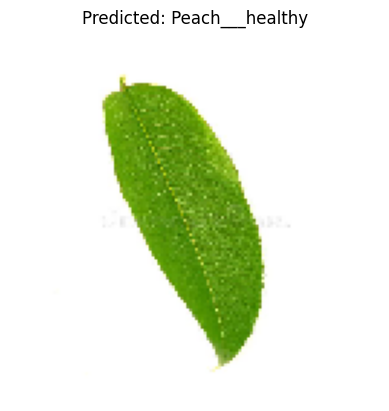

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os # Import os module

# Get the list of uploaded file names
uploaded_files = list(uploaded.keys())

# Check if any files were uploaded
if uploaded_files:
    # Use the first uploaded file name
    img_filename = uploaded_files[0]
    print(f"Using uploaded file: {img_filename}")

    # Path to uploaded image (now using the actual filename)
    img_path = os.path.join('/content/', img_filename) # Construct the full path

    # Load and preprocess image
    try:
        # Use IMG_SIZE[0] for height and IMG_SIZE[1] for width
        img = image.load_img(img_path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize (same as training)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        pred = model.predict(img_array)
        predicted_class_index = np.argmax(pred, axis=1)[0]

        # Get class label
        # Ensure class_labels are available (they should be from the generator)
        if 'class_labels' in globals() and predicted_class_index < len(class_labels):
             predicted_class_name = class_labels[predicted_class_index]
        else:
             predicted_class_name = f"Unknown Class Index: {predicted_class_index}"
             print("Warning: class_labels might not be correctly populated or index out of bounds.")


        # Display result
        print(f"Predicted Class: {predicted_class_name}")
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class_name}")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file {img_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

else:
    print("No files were uploaded. Please upload an image file using files.upload().")